Import libraries

In [62]:
import shap
shap.initjs() #helps with the ability to display images in notebook
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
df = pd.read_csv('final_data.csv')
df['median_income'] = df['median_income'].fillna(df['median_income'].mean()) # make sure response has no NAs

# get my X and Y matrices
X = df.drop(columns = ['median_income'])
features = X.columns
y = df['median_income']
# extract only the column names for each type
numeric_features = X.select_dtypes(include = ['number']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307) # split the data
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# make transformers for each data type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                  
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('filtering', SelectPercentile(f_regression, percentile=50))     
])

# run both through the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      
        ('cat', categorical_transformer, categorical_features)  
    ])

In [35]:
# need to deal with categorical
X_train_processed = preprocessor.fit_transform(X_train, y_train_log)
X_test_processed = preprocessor.transform(X_test)

In [36]:
# Access the OneHotEncoder and SelectPercentile steps
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
selector = preprocessor.named_transformers_['cat'].named_steps['filtering']

# Get all one-hot encoded feature names
onehot_feature_names = onehot.get_feature_names_out(categorical_features)

# Apply the SelectPercentile mask
mask = selector.get_support()  # Boolean mask of selected features
selected_categorical_features = onehot_feature_names[mask]

final_feature_names = list(numeric_features) + list(selected_categorical_features)


In [5]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}
gb_grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose = 1
)
gb_grid_search.fit(X_train_processed, y_train_log)
print(f"Best Parameters: {gb_grid_search.best_params_}")
# Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
print(f"Best MSE: {-gb_grid_search.best_score_}")
# Best MSE: 132159.55162585393
y_test_pred = gb_grid_search.predict(X_test_processed)
mse = root_mean_squared_error(y_test_log, y_test_pred)
print(f'Test rMSE: {mse}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best MSE: 3.6140957474771726e-05
Test rMSE: 0.006300954981604688


In [38]:
model = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0,
    random_state=42  
)

model.fit(X_train_processed, y_train_log)
y_pred_model = model.predict(X_test_processed)

# SHAP

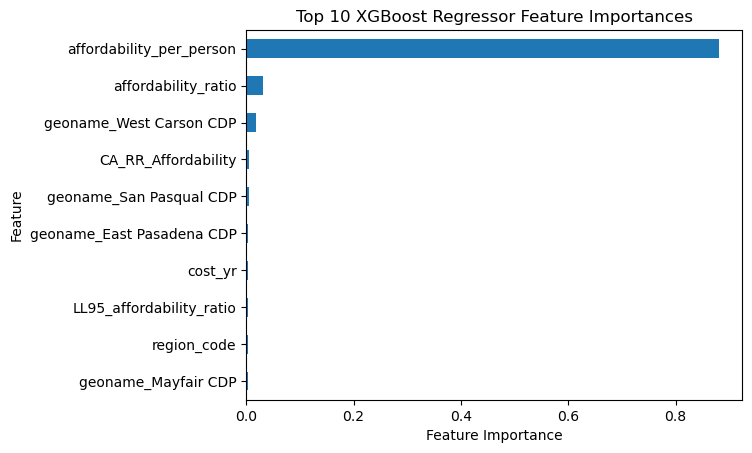

In [41]:
# Create a Series for feature importances
feature_importances = pd.Series(model.feature_importances_, index=final_feature_names)

# Select the top 10 features
top_10_features = feature_importances.nlargest(10)

# Plot the top 10 feature importances
top_10_features.plot.barh()
plt.title('Top 10 XGBoost Regressor Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

### Get Accuracy Stuff

In [ ]:
# Calculate errors
errors = y_test_log - y_test_pred
abs_errors = np.abs(errors)

# Define thresholds
acceptable_error = 0.0001 * y_test_log  # Tolerance low because rMSE low and values are on log scale
large_error_threshold = 0.0002 * y_test_log  # Significant error low for same reason

results = pd.DataFrame({
    'Actual': y_test_log,
    'Predicted': y_test_pred,
    'Error': errors,
    'Absolute_Error': abs_errors
})

# Classify predictions
results['Category'] = np.where(
    abs_errors <= acceptable_error, 'TP/TN',  # Accurate predictions (True Positives/Negatives)
    np.where(
        errors > large_error_threshold, 'FP',  # Overprediction (False Positive)
        np.where(
            errors < -large_error_threshold, 'FN',  # Underprediction (False Negative)
            'Other'  # Cases not meeting other criteria
        )
    )
)

# True Positives/Negatives (low error within acceptable range)
tp_tn = results[results['Category'] == 'TP/TN'].head(5)

# False Positives (significant overprediction)
fp = results[results['Category'] == 'FP'].head(5)

# False Negatives (significant underprediction)
fn = results[results['Category'] == 'FN'].head(5)

print("True Positives/Negatives (TP/TN):")
print(tp_tn)

print("\nFalse Positives (FP):")
print(fp)

print("\nFalse Negatives (FN):")
print(fn)

True Positives/Negatives (TP/TN):
           Actual  Predicted     Error  Absolute_Error Category
76012   10.546393  10.546453 -0.000060        0.000060    TP/TN
171844  10.546393  10.546652 -0.000258        0.000258    TP/TN
38795   10.546393  10.545941  0.000452        0.000452    TP/TN
154986  10.546393  10.546486 -0.000092        0.000092    TP/TN
149589  10.546393  10.546423 -0.000029        0.000029    TP/TN

False Positives (FP):
           Actual  Predicted     Error  Absolute_Error Category
158607  10.940473  10.914003  0.026469        0.026469       FP
34204   10.546393  10.544234  0.002159        0.002159       FP
205480   9.780189   9.773149  0.007040        0.007040       FP
183378  10.546393  10.544180  0.002214        0.002214       FP
111886  10.077021  10.074231  0.002789        0.002789       FP

False Negatives (FN):
           Actual  Predicted     Error  Absolute_Error Category
164199   8.405815   8.715989 -0.310175        0.310175       FN
89566   10.245374  10.24

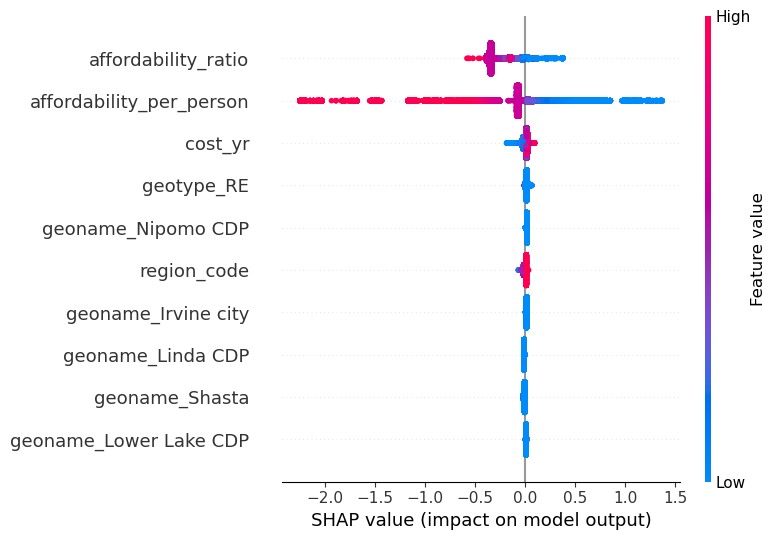

In [43]:
# create explainer for trained model
X_train_dense = X_train_processed.toarray()
X_train_dense_df = pd.DataFrame(X_train_dense, columns=final_feature_names)

# Create SHAP explainer for the model
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer.shap_values(X_train_dense_df)

# Visualize SHAP values with feature names
shap.summary_plot(shap_values, X_train_dense_df, max_display=10)


In [ ]:
# Replace 'index' with the index of the row you want to explain
shap.force_plot(explainer.expected_value[0], shap_values.values[index, :], X_train_dense[index, :])

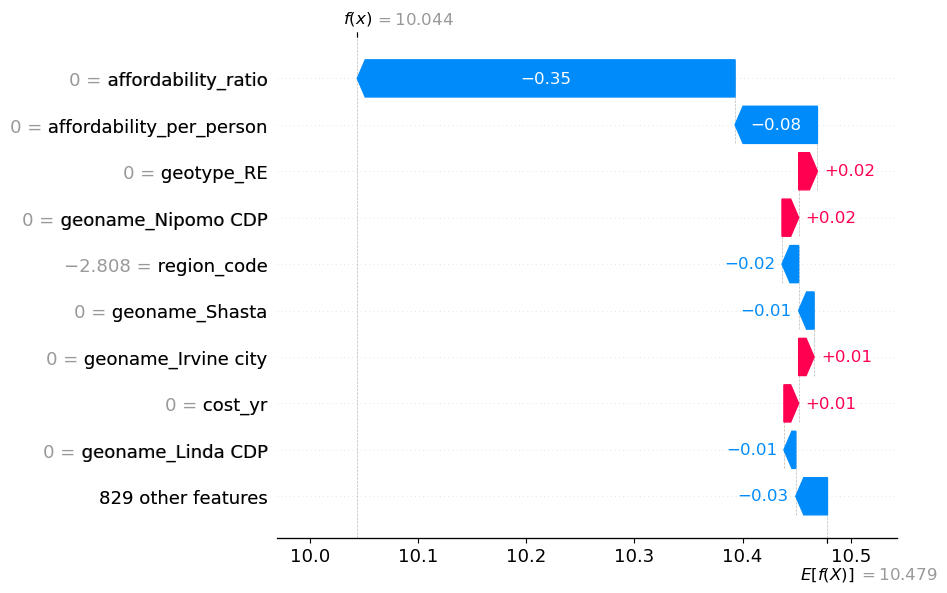

In [49]:
# what is on class notes
exp = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value,  # Scalar value
    data=X_train_dense_df.values,
    feature_names=final_feature_names
)

idx = 10
shap.plots.waterfall(exp[idx])

In [52]:
explainer.expected_value

10.478549

In [ ]:
# Force plot for the first prediction
shap.force_plot(
    explainer.expected_value,  # baseline prediction (average of all predictions output)
    exp.values[0],  # SHAP values for the first prediction
    # each feature contributes negatively to the base value
    exp.data[0],  # Feature values for the first prediction
    # actual values of the features for this instance
    feature_names=exp.feature_names
)


Interpretation: `affordability_per_person` contributes -1.632, pushing the prediction lower than the average. `affordability_ratio` contributes -1.496, also pulling the prediction lower. Note that I had to take the log of price so in regular terms it is $35544.79 rather than 10.47 as the baseline

In [53]:
np.exp(10.478549)

35544.79460865981

# Anomaly Detection

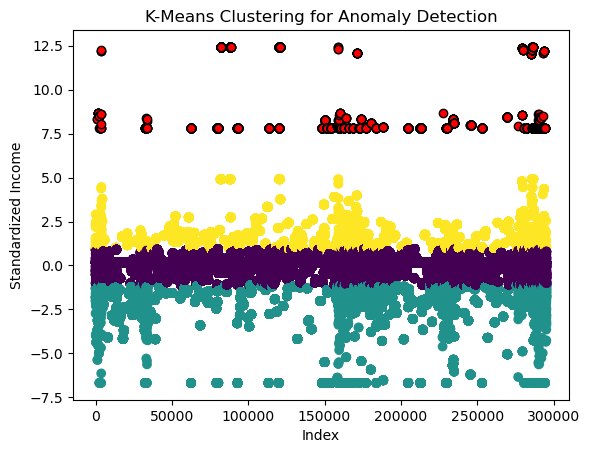

In [59]:
# anomaly detection on income with K Means

df['median_income_log'] = np.log1p(df['median_income'])
cluster = df[['median_income_log']]
# standardize income 
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster)

# fit K Means
kmeans = KMeans(n_clusters=3, random_state = 42)
df['income_cluster'] = kmeans.fit_predict(cluster_scaled)
# distances to centroid
distances = np.abs(cluster_scaled - kmeans.cluster_centers_[df['income_cluster']])
df['income_dist_centroid'] = distances

# set threshold
threshold = np.percentile(df['income_dist_centroid'], 99) # capture top 1% of anomalies

# label anomalies
df['is_anomaly'] = df['income_dist_centroid'] > threshold

# get anomalies
anomalies = df[df['is_anomaly']]

# visualize anomalies
plt.scatter(df.index, cluster_scaled, c=df['income_cluster'], cmap='viridis', label='Clusters')

plt.scatter(df[df['is_anomaly']].index, df[df['is_anomaly']]['median_income_log'], color='red', label='Anomalies', edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Standardized Income')
plt.title('K-Means Clustering for Anomaly Detection')
#plt.legend()
plt.show()

In [ ]:
# Analyze centroids
#print(kmeans.cluster_centers_)

silhouette = silhouette_score(X, df_here['cluster'])
print(f'Silhouette Score: {silhouette}')

/var/folders/8f/l9_yqvn54_ldh6kclbdcgvfh0000gn/T/ipykernel_8812/355327004.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_here['cluster'] = kmeans.fit_predict(X)


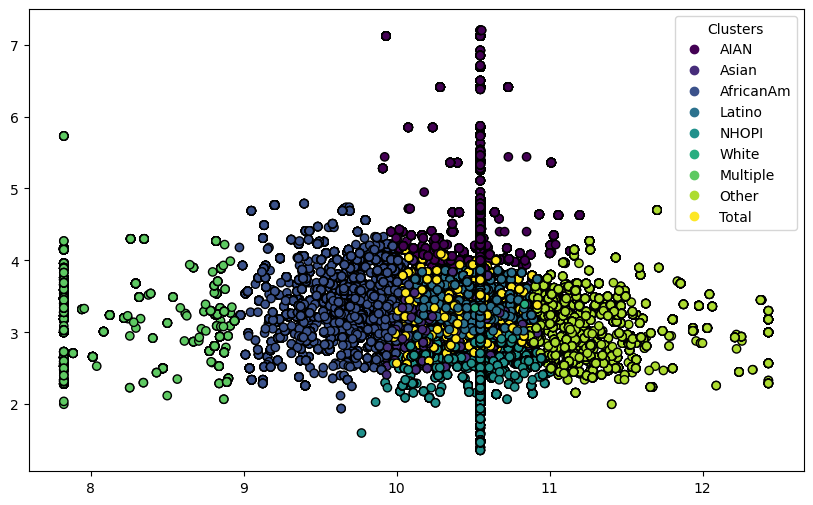

In [60]:
# anomaly detection on income, family size, race with K Means
features = df[['median_income_log','ave_fam_size', 'race_eth_name']]

df_here = df.dropna(subset=['median_income_log','ave_fam_size', 'race_eth_name'])  # Drop rows with missing values

# preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['median_income_log', 'ave_fam_size']),  # Scale numeric features
        ('cat', OneHotEncoder(), ['race_eth_name'])  # Encode categorical features
    ]
)

X = preprocessor.fit_transform(df_here)

# fit K Means
n_clusters = df['race_eth_name'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
df_here['cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_here['median_income_log'],
    df_here['ave_fam_size'],
    c=df_here['cluster'],  # Color by cluster
    cmap='viridis',
    edgecolor='k'
)

handles, _ = scatter.legend_elements()
legend_labels = df['race_eth_name'].unique()
plt.legend(handles, legend_labels, title="Clusters")

In [61]:
# Analyze centroids
#print(kmeans.cluster_centers_)

silhouette = silhouette_score(X, df_here['cluster'])
print(f'Silhouette Score: {silhouette}')

[[ 1.38097589e-01  1.70889526e+00  1.35053955e-01  1.21593058e-01
   1.26098565e-01  6.87506953e-02  1.34914896e-01  1.14806986e-01
   1.31577484e-01  5.28145511e-02  1.14389810e-01]
 [-1.44802406e-01 -1.22304566e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.83778478e+00  2.31768032e-01  3.70370370e-02  1.51083484e-01
   7.70525771e-02  2.90814124e-01  5.68937236e-02  1.20003453e-02
   1.16118449e-02  2.36898904e-01  1.26607960e-01]
 [ 1.49655132e-01  1.19822548e-01  1.90858719e-01  1.63038438e-01
   1.56326796e-01  0.00000000e+00  1.70387629e-01  0.00000000e+00
   1.95912737e-01  0.00000000e+00  1.23475680e-01]
 [ 1.96162425e-01 -1.15778961e+00  1.48732394e-01  1.35343828e-01
   1.25799503e-01  6.06959403e-02  1.41143331e-01  6.08450704e-02
   1.48931234e-01  7.09527755e-02  1.07555924e-01]
 [ 1.64647067e-01 -7.63491533e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  